<h1><center>Matryoshka Games<h1/><center/>



## Задание1:

* Приведите таблицу в удобный вид (на ваш вкус) и приложите в формате Excel. Не увлекайтесь оформлением, главное - удобство работы с данными.
* Для каждого уровня в обеих когортах посчитайте процент отвала игроков.
* Какие еще сведения способные улучшить игру можно получить из этих данных? Внесите их в вашу таблицу.
* Перед вами стоит выбор - заменить старые 30 уровней новыми, или нет?Почему?

## Задание2:

* Основываясь на данных из таблицы сделайте для лучшей, по вашему мнению,когорты прогноз, какой процент пользователей дойдет до 240, 360, 480, 600 уровня.
* Сколько в среднем уровней на данный момент проходит пользователь? Спрогнозируйте, сколько уровней проходил бы пользователь в среднем, если бы в игре было 240,360,480,600 уровней.
* Предположите, сколько нужно уровней, чтобы снять достоверный Retention D30?

In [257]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings("ignore") 
from tqdm import tqdm_notebook
import os, re, sys, gc

from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from sklearn.linear_model import LinearRegression

In [2]:
# путь к данным
PATH_TO_FILE = r'C:\Users\Sergey\anaconda3\Scripts\ab_test_levels2.xlsx'

## Загрузка данных

In [3]:
# загружаем данные
df = pd.read_excel(PATH_TO_FILE)

In [4]:
df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,\tFormula,\tUNIQUES(A);TOTALS(A);TOTALS(B);TOTALS(C);TOT...,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,\tA:,\tlevel_start,\tlevel_number,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Подготовка данных
* удалим nan
* соберем шапку таблицы
* заменим значения в колонке Formula
* заменим значения в колонке Segment
* переименуем колонки: [показатель].[характеристика показателя].[статистика]
* разделим на когорты A, B

In [5]:
# удаляем nan
df_notna = df.dropna().reset_index(drop = True)

# названия признаков
colnames = []
for val in df_notna.iloc[0].values:
    try:
        colnames.append(val.strip())
    except:
        colnames.append(val)

df_notna_c = df_notna.drop(0).rename(columns = dict(zip(df_notna.columns, colnames)))
df_notna_c = df_notna_c.astype(str).applymap(lambda val: val.strip()).replace('', np.nan)

# значения в Formula
Formula_unique_values = df_notna_c['Formula'].unique()
Formula_replacements = 'level.start.unique', 'level.start.total', 'level.won.total' ,'level.losed.total', 'level.quit.total'
Formula_d = dict(zip(Formula_unique_values, Formula_replacements))
df_notna_c['Formula'] = df_notna_c['Formula'].map(Formula_d)

# значения в Segment
Segment_unique_values = df_notna_c['Segment'].unique()
Segment_replacements = ['A', 'B']
Segment_d = dict(zip(Segment_unique_values, Segment_replacements))
df_notna_c['Segment'] = df_notna_c['Segment'].map(Segment_d)

# собираем level_number в один столбец
ser_level_number = df_notna_c.rename(columns = {'level_number' : 'level.number'})['level.number'].astype(np.float32).sum(1).astype(int)
df_notna_c = df_notna_c.drop('level_number', 1)
df_notna_c['level.number'] = ser_level_number

df_notna_c = df_notna_c.rename(columns = {df_notna_c.columns[2]:'event/player_total'})

# когорта A
df_A = df_notna_c[df_notna_c['Segment'] == 'A']\
                 .groupby(['Formula', 'level.number'])\
                 ['event/player_total'].sum()\
                 .unstack(0).fillna(0).astype(int)
df_A.columns.name = None

# когорта Б
df_B = df_notna_c[df_notna_c['Segment'] == 'B']\
                 .groupby(['Formula', 'level.number'])\
                 ['event/player_total'].sum()\
                 .unstack(0).fillna(0).astype(int)
df_B.columns.name = None

In [6]:
df_A.head()

,level.losed.total,level.quit.total,level.start.total,level.start.unique,level.won.total
level.number,,,,,
1,0,21,1756,1750,1716
2,0,18,1679,1672,1652
3,0,30,1621,1602,1587
4,7,42,1557,1525,1490
5,4,30,1429,1406,1383


## Игровой процесс

<img src="matryoshka_pipeline.png">

In [7]:
# кф корреляции
L_corr = []

# датасетов A, B
for flag, df in zip(('A', 'B'), (df_A, df_B)):
    # считаем попраные корреляции для всех признаков
    for i in range(df.shape[1]):
        for j in range(i+1, df.shape[1]):
            col_A, col_B = df.columns[i], df.columns[j]
            ser1, ser2 = df[col_A], df[col_B]
            L_corr.append((flag, col_A, col_B, np.corrcoef(ser1, ser2).min()))  

# финальная таблица
df_corr_AB = pd.DataFrame(L_corr,\
                          columns = ['cohort', 'feature_1', 'feature_2', 'corr_coef'])

# собираем посчитанные корреляции в одну таблицу
L2_corr = []
for (f1, f2), _subdf in df_corr_AB.groupby(['feature_1', 'feature_2']):
    corr1, corr2 = _subdf['corr_coef'].round(4).values.tolist()
    L2_corr.append((f1, f2, corr1, corr2))  

# финальная таблица    
df2_corr_AB = pd.DataFrame(L2_corr,\
                           columns = ['feature_1', 'feature_2', 'corr.A', 'corr.B'])\
                .sort_values('corr.A')\
                .reset_index(drop = True)\
                .set_index(['feature_1', 'feature_2'])

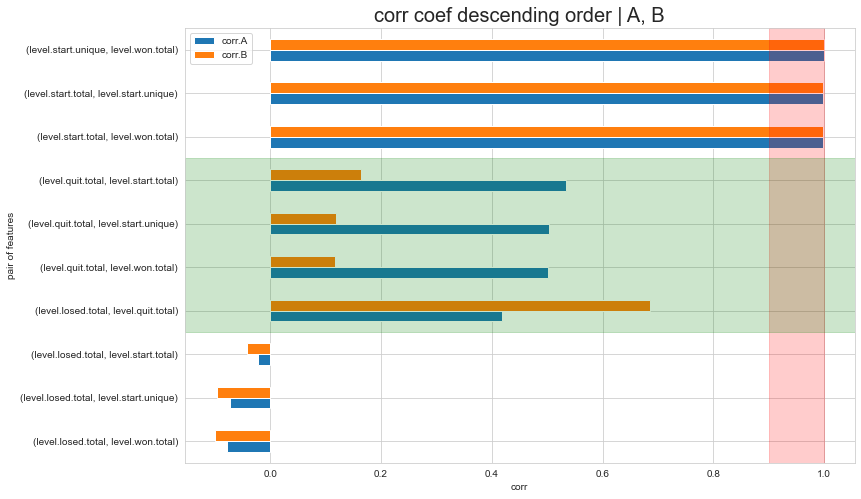

In [8]:
df2_corr_AB.plot(kind = 'barh', figsize = (12, 8))
plt.axvspan(.9, 1, color = 'red', alpha = .2)
plt.axhspan(2.5, 6.5, alpha = .2, color = 'green')
plt.title('corr coef descending order | A, B', fontsize =20)
plt.xlabel('corr')
plt.ylabel('pair of features')
plt.show()

#### Выводы:
* мультиколлинеарные признаки: ['level.start.total', 'level.won.total', 'level.start.unique'] (можно будет оставить один из них)
* пары признаков, корреляция между которыми сильно отличается в A, B

|признак1|признаки2|
|---|---|
|level.quit.total|level.won.total, level.start.unique, level.start.total|
|level.losed.total|level.quit.total, level.start.total|

* значение level.quit.total в когортах A, B различное


In [9]:
mnmx_scaler = MinMaxScaler()

df_A['level.churn'] = df_A['level.start.total'].diff(-1)
df_A['level.churn.unique'] = df_A['level.start.unique'].diff(-1)
df2_A = df_A.drop(['level.start.total', 'level.start.unique', 'level.won.total'], 1).dropna()
df2_A['level.churn.unique_normed'] = mnmx_scaler.fit_transform(df2_A[['level.churn.unique']]).flatten()

df_B['level.churn'] = df_B['level.start.total'].diff(-1)
df_B['level.churn.unique'] = df_B['level.start.unique'].diff(-1)
df2_B = df_B.drop(['level.start.total', 'level.start.unique', 'level.won.total'], 1).dropna()
df2_B['level.churn.unique_normed'] = mnmx_scaler.fit_transform(df2_B[['level.churn.unique']]).flatten()

df_level_start_unique_normed_AB = pd.concat([pd.Series(mnmx_scaler.fit_transform(df_A[['level.start.unique']]).flatten(),\
                                                       index =df_A.index),\
                                             pd.Series(mnmx_scaler.fit_transform(df_B[['level.start.unique']]).flatten(),\
                                                       index =df_A.index)], 1)
df_level_start_unique_normed_AB.columns = ['A', 'B']

B_less_A_mask = df_level_start_unique_normed_AB['B'] > df_level_start_unique_normed_AB['A']
level_number = df_A.index
level_number_B_less_A = level_number[B_less_A_mask]
level_start_stop = np.argwhere(np.diff(level_number_B_less_A) != 1).flatten()[[0, 1]]

In [10]:
# параметры
COLS_TO_GET_TOP_IDXS= ['level.losed.total', 'level.quit.total', 'level.churn']
COLORS = ['blue', 'gray', 'red']
ALPHAS = [.5, .5, 1]
N_TOP = 10
MUL = 10
figsize = (20, 7)
ALPHA = .05

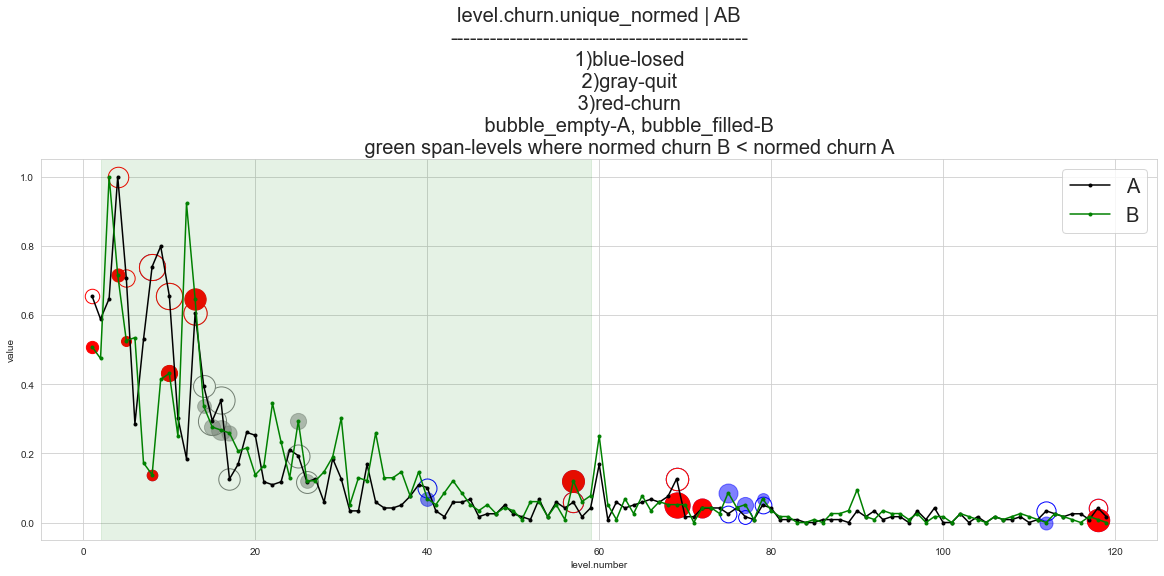

In [11]:
fig, axes = plt.subplots(1, 1, figsize = (20, 7))
for color, df in zip(('black', 'green'), (df2_A, df2_B)):
    
    # нормированный отток
    df['level.churn.unique_normed'].plot(marker = '.', color =color, ax = axes)
    
    if color =='black':        
        # топ N уровней с оттоком, поражениями, выходами
        for col, color, alpha in zip(COLS_TO_GET_TOP_IDXS, COLORS, ALPHAS):
            top_idxs = df2_A[col].sort_values(ascending = False).head(N_TOP).index
            for idx in top_idxs:
                plt.scatter(idx,\
                            df.loc[idx, 'level.churn.unique_normed'],\
                            color = 'white',\
                            s = MUL*df.loc[idx, 'level.quit.total'],\
                            alpha = 1, edgecolor = color)
    else:
        # топ N уровней с оттоком, поражениями, выходами
        for col, color, alpha in zip(COLS_TO_GET_TOP_IDXS, COLORS, ALPHAS):
            top_idxs = df2_A[col].sort_values(ascending = False).head(N_TOP).index
            for idx in top_idxs:
                plt.scatter(idx,\
                            df.loc[idx, 'level.churn.unique_normed'],\
                            color = color,\
                            s = MUL*df.loc[idx, 'level.quit.total'],\
                            alpha = alpha)
                
plt.legend(['A', 'B'], fontsize = 20)   
plt.title('level.churn.unique_normed | AB\n---------------------------------------------\n\
           1)blue-losed\n\
           2)gray-quit\n\
           3)red-churn\n\
           bubble_empty-A, bubble_filled-B\n\
           green span-levels where normed churn B < normed churn A', fontsize = 20)
axes.axvspan(level_start_stop[0], level_start_stop[1], alpha = .1, color = 'green')
plt.ylabel('value')
plt.show()

#### Вывод:
* массовый отток пользователей наблюдается в начале игры у когорты А(скучыне/сложные уровни(уровень скучный, если игрок вышел из него без поражения. это мы проверим позже)), в когорте B также наблюдаются выходы, но в меньшем размере. Уровни стали интреснее/сбалансированнее
* уровни примерно 10-20 являются скучными для игроков обеих когорт, но ситуация в когорте B лучше
* отток и поражения в уровнях с 59 примерно одинаковые в обеих когортах. Данные отрезки являются игровыми чекпоинтами("боссами")
* начиная с уровня 59, отток в обеих когортах одинаковый. Данные уровни стоит проработать отдельно

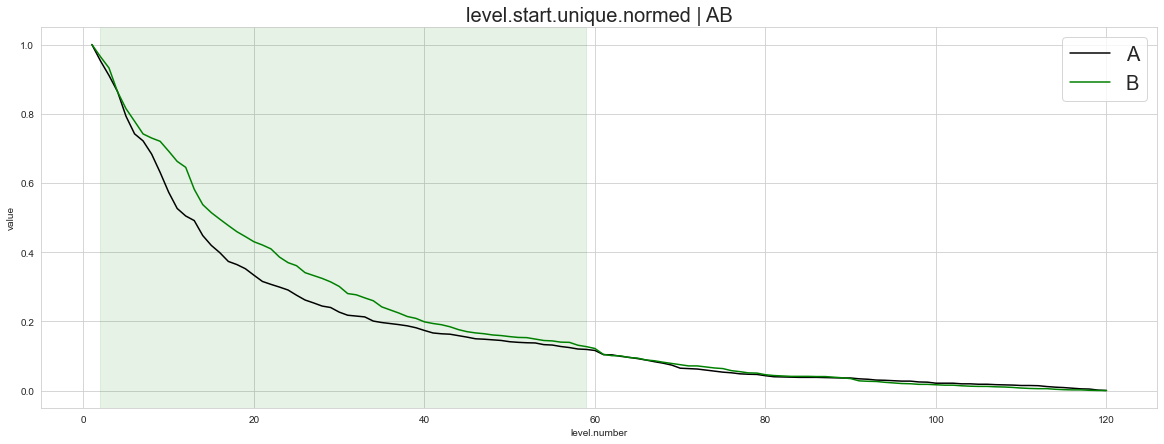

In [12]:
fig2, axes2 = plt.subplots(1, 1, figsize = (20, 7))

df_level_start_unique_normed_AB.plot(color=['black', 'green'], ax = axes2)
plt.axvspan(level_start_stop[0], level_start_stop[1], color ='green', alpha = .1)
plt.legend(['A', 'B'], fontsize = 20) 
plt.title('level.start.unique.normed | AB', fontsize = 20)
plt.ylabel('value')
plt.show()

#### Вывод:
* уровни 2-59 в когорте B удерживают лучше, чем в когорте A

In [13]:
df_quit_no_lose_A = df_A[(df_A['level.losed.total']==0) & (df_A['level.quit.total']!=0)]
df_quit_no_lose_B = df_B[(df_B['level.losed.total']==0) & (df_B['level.quit.total']!=0)]


df_quit_rate_AB = pd.DataFrame()
df_quit_rate_A = (df_quit_no_lose_A['level.quit.total'] / df_quit_no_lose_A['level.start.total'])                    
df_quit_rate_B = (df_quit_no_lose_B['level.quit.total'] / df_quit_no_lose_B['level.start.total'])
for k, v in df_quit_rate_A.items():
    df_quit_rate_AB.loc[k, 'A'] = v
for k, v in df_quit_rate_B.items():
    df_quit_rate_AB.loc[k, 'B'] = v
df_quit_rate_AB = df_quit_rate_AB.sort_index().fillna(0)

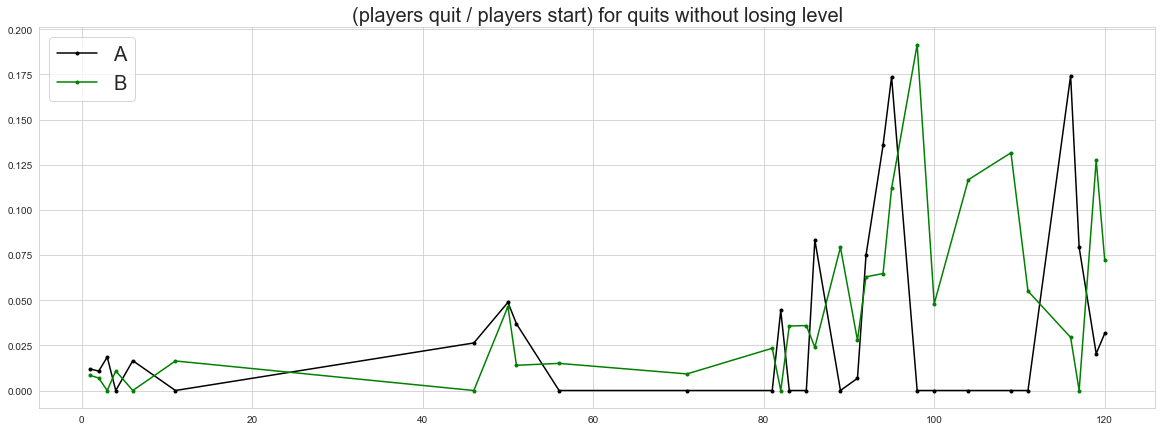

In [14]:
df_quit_rate_AB.plot(marker ='.', figsize = figsize, color=['black', 'green'])
plt.legend(['A', 'B'], fontsize = 20) 
plt.title('(players quit / players start) for quits without losing level', fontsize=20)
plt.show()

#### Вывод:
* игроки покидают уровень, когда ему предшестовала череда сложных, или когда он слишком скучный
* как видно, в когроте А многие выходили на первых трех уровнях, в когорте B начальныеуровни интереснее

In [15]:
# минималальное число записей дляучета группы
MIN_SAMPLES_LEAF = 5

def _do_kolmogorov_smirnov_test_AB(ser_A, ser_B, alpha):
    '''Тест Коломогорва-Смиронова на идентичность распределений'''
    if stats.ks_2samp(ser_A, ser_B)[1] > alpha:
        return('распределения идентичны, alpha = {:.0%}'.format(1-alpha))
    else:
        return('распределения не идентичны, alpha = {:.0%}'.format(1-alpha))

def _bootstrap_means_AB(ser_A,ser_B, sample_size, n_samples, alpha):
    '''
    тестирует идентичность средних в двух выборках с помощью бутстрепа
    
    параметры:
        sample_size - размер бутстреп выборки
        n_samples - число бутстреп выборок
    '''
    bt_means_A=[ser_A.sample(sample_size).mean() for _ in range(n_samples)]
    bt_means_B=[ser_B.sample(sample_size).mean() for _ in range(n_samples)]
    if stats.ttest_ind(bt_means_A, bt_means_B)[1]<alpha:
        return ('различий в средних нет на уровне значимости {:.0%}'.format(1-alpha))
    else:
        return ('различия в средних есть на уровне значимости {:.0%}'.format(1-alpha))
        

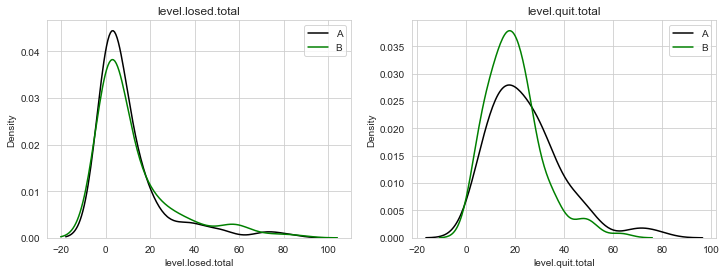

In [16]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

sns.kdeplot(df_A['level.losed.total'], ax = axes[0], color ='black')
sns.kdeplot(df_B['level.losed.total'], ax = axes[0], color='green')
axes[0].set_title('level.losed.total')
axes[0].legend(['A', 'B'])

sns.kdeplot(df_A['level.quit.total'], ax = axes[1], color='black')
sns.kdeplot(df_B['level.quit.total'], ax = axes[1], color='green')
axes[1].set_title('level.quit.total')
axes[1].legend(['A', 'B'])
plt.show()

#### Вывод:
* в A из кровней выходит больше людей, чем в B

In [17]:
for feat_name in ('level.losed.total', 'level.quit.total'):
    
    vals_A = np.around(mnmx_scaler.fit_transform(df2_A[[feat_name]]).flatten(), 2)
    vals_B = np.around(mnmx_scaler.fit_transform(df2_B[[feat_name]]).flatten(), 2)
    to_use = np.intersect1d(vals_A, vals_B)

    for x in to_use:
        idxs_A = np.argwhere(vals_A==x).flatten()
        idxs_B = np.argwhere(vals_B==x).flatten()
        if (len(idxs_A)>=MIN_SAMPLES_LEAF)&(len(idxs_B)>=MIN_SAMPLES_LEAF):
            ser_A=df2_A.loc[df2_A.index[idxs_A],'level.churn.unique']
            ser_B=df2_B.loc[df2_B.index[idxs_B],'level.churn.unique']
            ks_test_AB =_do_kolmogorov_smirnov_test_AB(ser_A, ser_B, alpha=ALPHA)     
            compare_means_AB = _bootstrap_means_AB(ser_A,ser_B, sample_size=5, n_samples=100, alpha = ALPHA)
            value=df2_A.loc[df2_A.index[idxs_A],feat_name].unique()[0]
            print('признак={}, значение = {}\nраспределения level.churn.unique AB: {}\n{}'\
                         .format(feat_name, value, ks_test_AB,compare_means_AB))
            print('---------------------------------------------------------------')
        

признак=level.losed.total, значение = 0
распределения level.churn.unique AB: распределения идентичны, alpha = 95%
различий в средних нет на уровне значимости 95%
---------------------------------------------------------------
признак=level.losed.total, значение = 1
распределения level.churn.unique AB: распределения идентичны, alpha = 95%
различий в средних нет на уровне значимости 95%
---------------------------------------------------------------
признак=level.losed.total, значение = 2
распределения level.churn.unique AB: распределения не идентичны, alpha = 95%
различий в средних нет на уровне значимости 95%
---------------------------------------------------------------
признак=level.losed.total, значение = 4
распределения level.churn.unique AB: распределения идентичны, alpha = 95%
различий в средних нет на уровне значимости 95%
---------------------------------------------------------------
признак=level.quit.total, значение = 15
распределения level.churn.unique AB: распределения ид

#### Вывод:
* распределения оттока, средние оттока в разных группах _level.losed.total_, _level.quit.total_ для А, B идентичны

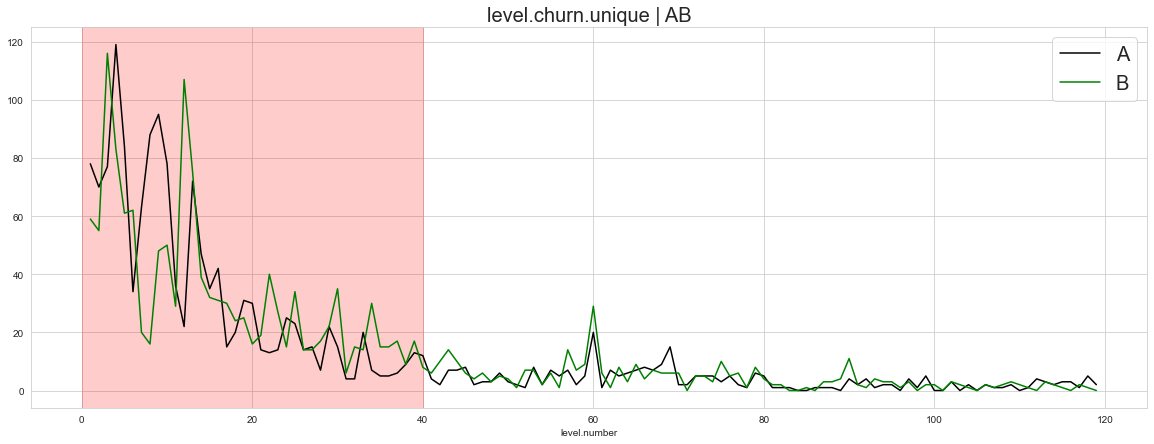

In [18]:
df2_A['level.churn.unique'].plot(color ='black', figsize =figsize)
df2_B['level.churn.unique'].plot(color ='green')
plt.axvspan(0, 40, color='red', alpha =.2)
plt.title('level.churn.unique | AB', fontsize = 20)
plt.legend(['A', 'B'], fontsize = 20)
plt.show()

#### Вывод:
* отток становится примерно стационарным после 40-го уровня
* для получения прогноза используем данный отрезок когорты B

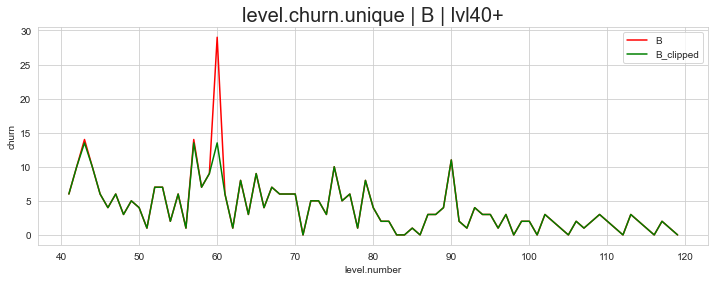

In [19]:
churn_after_40_B = df2_B['level.churn.unique'].iloc[40:].to_frame('B')
q25, q75 = churn_after_40_B['B'].quantile([.25, .75])
iqr = q75-q25
churn_after_40_B['B_clipped'] = churn_after_40_B['B'].apply(lambda x: x if (x<q75+1.5*iqr) else q75+1.5*iqr)

churn_after_40_B.plot(color = ['red', 'green'], figsize = (12, 4))
plt.title('level.churn.unique | B | lvl40+', fontsize = 20)
plt.ylabel('churn')
plt.show()

In [20]:
ser_B = df_B.iloc[40:]['level.start.unique']

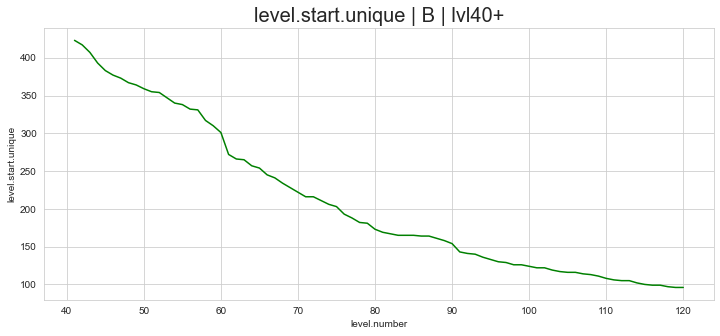

In [21]:
ser_B.plot(color ='green', figsize = (12, 5))
plt.title('level.start.unique | B | lvl40+', fontsize = 20)
plt.ylabel('level.start.unique')
plt.show()

In [319]:
def _get_forecast(ser, history_len, forecast_len):
    '''
    делает прогноз на forecast_len значений с помощью линейной регрессии
    на основе исторических данных размером history_len
    '''
    
    # линейная регрессия
    lr= LinearRegression()

    # данные, на которых обучаемся
    forecast_B = ser.iloc[-history_len:].to_frame('fit')
    # последний индекс
    idx_max = forecast_B.index.max()   
    # индексы прогноза
    idx_forecast = np.arange(idx_max+1, idx_max+forecast_len+1)
    
    # признаки, таргет
    x = forecast_B.index.values.reshape(-1,1)
    y = forecast_B['fit'].values.reshape(-1,1)
    
    # фитим модель
    lr.fit(x,y)

    # задаем индексы для прогноза
    for i in idx_forecast:
        forecast_B.loc[i, 'forecast'] = np.nan 
    
    # делаем прогноз    
    forecast_B.loc[idx_forecast, 'forecast'] = lr.predict(forecast_B.iloc[-forecast_len:].index.values.reshape(-1,1)).flatten()
    
    # добавляем исторические значения
    rep = pd.concat([ser.to_frame('history'), forecast_B], 1)
    rep.loc[rep['history'].dropna().index[-history_len:], 'history'] = np.nan
    
    return rep

In [320]:
forecast_h_12_f_10_B= _get_forecast(df_B['level.start.unique'], history_len=12, forecast_len=10)

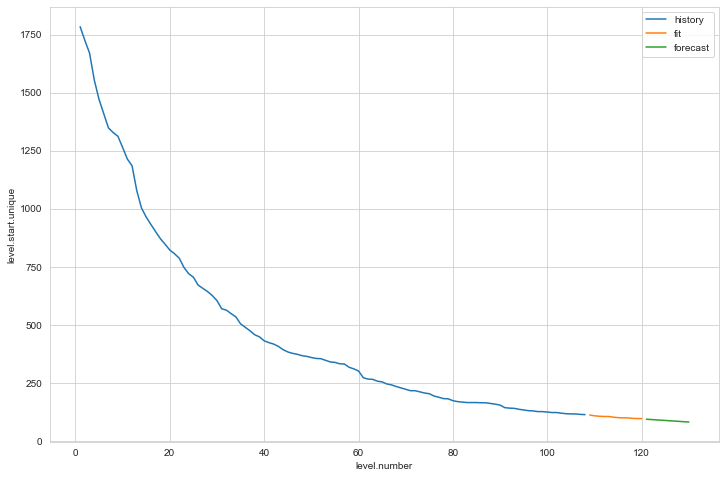

In [321]:
forecast_h_12_f_10_B.plot(figsize = (12, 8))
plt.ylabel('level.start.unique')
plt.show()